**задача ранжирования**

Евгений Борисов <esborisov@sevsu.ru>

----

**задача ранжирования**

$X \subset \mathbb{R}^n $ - множество объектов   

подмножество $X_\mathscr{l}=\{x_1...x_m\}\subset X$,
на котором задано отношение (частичного?) порядка

__задача__:  построить отображение $a(x) : X_\mathscr{l} \rightarrow \mathbb{R}$  такое, что
для $i<j \Rightarrow a(x_i)<a(x_j)$

__способы решения задачи ранжирования__

- _point-wise / поточечно_, строим функционал по каждому объекту отдельно;    
    сводится к задаче классификации/регрессии,  
    для каждого объекта задаём значение ранга и обучаем модель определять ранг объекта   


- _pair-wise / попарно_, строим функционал с парами объектов;    
    строим датасет упорядоченных пар и обучаем модель определять кто в паре первый


- _list-wise / списком_, оцениваем сразу список объектов и отношения на них;   
    на датасете задано отношение порядка, обучаем модель воспроизводить порядок 

__модели парного ранжирования (pair-wise)__

поределим понятие отступа как разницу скоров двух объектов:

$$M_{ij} = a(x_j) - a(x_i)$$

условие паного ранжирования это положительный отступ, т.е. $ M_{ij}>0 $ для $i<j$

приходим к задаче оптимизации - минимизировать количество отрицательных отступов

$$Q(a) = \sum\limits_{i<j} \left[ M_{ij} < 0  \right] \rightarrow \min $$


для использования градиентных методов перейдём к гладкому функционалу качества

$$Q(a) = \sum\limits_{i<j} \left[ M_{ij} < 0  \right] \leq \sum\limits_{i<j} \mathscr{L} \left( M_{ij} \right) \rightarrow \min $$

где  
$a(x)$ - алгоритм ранжирования  
$\mathscr{L}(M)$ - убывающая непрерывная функция отступа  

переход к гладкому функционалу качества ранжирования для оптимизации градиентными методами

разные варианты замены $Q(M)$ на гладкий функционал $\mathscr{L}(M)\geq Q(M) $

RankSVM:
$$\mathscr{L}(M) = \left(1-M\right)_+$$

RankBoost: 
$$\mathscr{L}(M) = \exp(-M)$$

RankNet:
$$\mathscr{L}(M) = \log\left(1+\exp(-\sigma M) \right)$$

**rankNet**

$a(x)=<w,x>$ линейная модель

$\mathscr{L}(M) = \log(1+\exp(-\sigma M) )$ гладкая апроксимация функционала качества

$\sigma$ - параметр

<span style='font-size:8pt;'>
Cristopher J.C. Burges, Tal Shaked, Erin Renshaw, Ari Lazier, Matt Deeds, Nicole Hamilton, Gregory N. Hullender. 
Learning to rank using gradient descent.   
In Proceedings of ICML’2005.
<a href='https://icml.cc/2015/wp-content/uploads/2015/06/icml_ranking.pdf'>
https://icml.cc/2015/wp-content/uploads/2015/06/icml_ranking.pdf    
</a>
</span>

$$\mathscr{L}(M) = \log(1+\exp(-\sigma M) )
= \log\left(
1+\exp\left(-\sigma \left( a(x_i,w)- a(x_j,w) \right) \right) 
\right)$$

$$
\frac{\partial \mathscr{L}}{\partial w} = 
\frac{1}{
1+\exp\left(-\sigma \left( a(x_i,w)- a(x_j,w) \right) \right) 
}\cdot
\exp\left(-\sigma \left( a(x_i,w)- a(x_j,w) \right) \right) 
\cdot -\sigma
\cdot \left( \frac{\partial a(x_i,w)}{\partial w} - \frac{\partial a(x_j,w)}{\partial w} \right) 
= \cdots
$$

$$
\cdots = 
\frac{
-\sigma
\cdot
\exp\left(-\sigma \left( a(x_i,w)- a(x_j,w) \right) \right) 
}{
1+\exp\left(-\sigma \left( a(x_i,w)- a(x_j,w) \right) \right) 
}
\cdot \left( \frac{\partial a(x_i,w)}{\partial w} - \frac{\partial a(x_j,w)}{\partial w} \right) 
$$

$$
\cdots = 
\frac{
-\sigma
}{
1+\exp\left( \sigma \left( a(x_i,w)- a(x_j,w) \right) \right) 
}
\cdot \left( \frac{\partial a(x_i,w)}{\partial w} - \frac{\partial a(x_j,w)}{\partial w} \right) 
$$

---

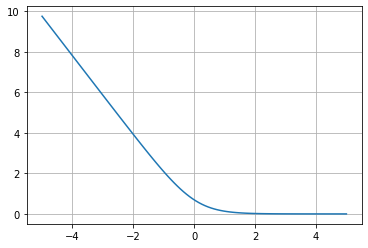

In [1]:
import numpy as np
import matplotlib.pyplot as plt

m = np.linspace(-5,5,100)
loss = lambda x,s: np.log(1.+np.exp(-s*x))
plt.plot(m,loss(m,1.95))
plt.grid()

In [2]:
# # показывать выдачу всех строк ячейки
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# import gzip
# import pickle

import numpy as np
import numpy.random as rng
# import pandas as pd
# import gc
from tqdm import tqdm

# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [4]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

In [5]:
# модельный датасет для парного ранжирования
n_samples = 10_000 # количество объектов
X = rng.rand(n_samples,2) # признаки объектов
# задаём парное отношение порядка
pair = np.array(list({  # уникальные пары с точностью до перестановки
        tuple(set([i,j])):[i,j] 
        for i,j in zip(rng.permutation(n_samples),rng.permutation(n_samples)) 
        if i!=j 
    }.values()))
pair.shape, X.shape

((9999, 2), (10000, 2))

100%|██████████| 120/120 [00:00<00:00, 378.87it/s, loss=0.693, lr=0.001]


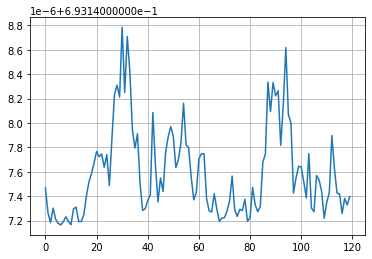

In [7]:
from lib.optimizer.gd import GD
from lib.optimizer.gd import SGD
from lib.loss.ranker import PairRankerLoss
from lib.optimizer.gd import EarlyStopping
from lib.model.linear import LinearModel
from lib.optimizer.lrate import ConstLRA
#from lib.optimizer.lrate import FactorLRA


model = LinearModel(n_features=X.shape[1],n_out=1 )

lra=ConstLRA(.001)
# lra =  FactorLRA(value=.01,bound=.001,factor=.9)
#es=EarlyStopping(min_delta=1e-3,patience=4)

#lsh,lrh = GD(PairRankerLoss(model),lra=lra,es=es).fit([X,pair],n_epoch=20)
# lsh,lrh = GD(PairRankerLoss(model),lra=lra).fit([X,pair],n_epoch=20)
lsh,lrh = SGD(
    PairRankerLoss(model),
    lra=lra
).fit(
    [X,pair],
    batch_size=len(pair)//10,
    n_epoch=120,
    target_is_indices=True,
)

plt.plot(lsh)
plt.grid()

---

In [ ]:
# from sklearn.metrics import ndcg_score
# from scipy.stats import spearmanr
# from scipy.stats import kendalltau

# def estimate(X,p):
#     p_[pair[:,0]], p_[pair[:,1]]
    
#     return [ # метрики ранжирования
#             # Normalized Discounted Commulative Gain (nDCG@K)    
#             ndcg_score( score_t[np.newaxis,:], score_r[np.newaxis,:],),
#             # коэффициент ранговой корреляции Спирмана
#             spearmanr( score_t, score_r, )[0],
#             # коэффициент ранговой корреляции tau Кендалла
#             kendalltau( score_t, score_r, )[0],
#         ]

---